In [1]:
# Import requirements
import numpy as np
import scanpy as sc
from timeit import default_timer as timer
import time
import sys
import os

In [2]:
# Please note the csv file in in_file has been modified with the addition of `gene_name` to the very beginning of the csv index.
in_file = "/home/cjnolet/covid_omics_local/Counts_lung_cells.csv"
out_dir = "."

min_disp = 0.5

In [3]:
%%time

start = time.time()

# Load data
adata = sc.read_csv(in_file)
adata = adata.T

CPU times: user 4min 12s, sys: 4.41 s, total: 4min 16s
Wall time: 4min 16s


In [4]:
%%time
## Filter cells with <200 genes and >6000 genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=6000)

## Filter cells with >15% MT reads
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs.percent_mito < 0.15, :]

## Remove zero columns
adata = adata[:,adata.X.sum(axis=0) > 0]

CPU times: user 16.5 s, sys: 9.41 s, total: 25.9 s
Wall time: 26 s


In [5]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 12.7 s, sys: 3.07 s, total: 15.7 s
Wall time: 15.7 s


In [6]:
%%time
sc.pp.log1p(adata)

/share/software/miniconda3/envs/cuml_dev_014_2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


CPU times: user 8.81 s, sys: 3.18 s, total: 12 s
Wall time: 12 s


In [7]:
%%time
if min_disp > 0:

    # Filter matrix to only variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=min_disp)
    
    n_genes = sum(adata.var.highly_variable)
    print("Selected " + str(n_genes) + " genes.")
    adata = adata[:, adata.var.highly_variable]

Selected 3338 genes.
CPU times: user 8.27 s, sys: 3.41 s, total: 11.7 s
Wall time: 11.7 s


In [8]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 11min 22s, sys: 43min 16s, total: 54min 39s
Wall time: 1min 49s


In [9]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.33 s, sys: 54.5 ms, total: 1.38 s
Wall time: 1.38 s


In [10]:
%%time
# PCA
# Note: This is a significant bottleneck but is made better by filtering highly variable genes above.
sc.tl.pca(adata, n_comps=50)

CPU times: user 3min 40s, sys: 1min, total: 4min 40s
Wall time: 10.4 s


In [11]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_pcs=50)

CPU times: user 16.4 s, sys: 201 ms, total: 16.6 s
Wall time: 16.6 s


In [12]:
%%time
# UMAP
sc.tl.umap(adata)

CPU times: user 1min 19s, sys: 2.86 s, total: 1min 21s
Wall time: 32.3 s


In [13]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 5.28 s, sys: 69.3 ms, total: 5.35 s
Wall time: 5.37 s


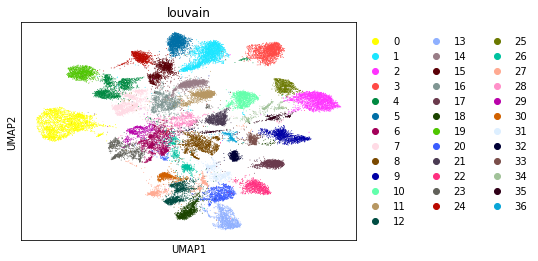

CPU times: user 471 ms, sys: 141 ms, total: 611 ms
Wall time: 457 ms


In [14]:
%%time
# Plot
sc.pl.umap(adata, color='louvain')

In [15]:
total_time = time.time() - start

In [16]:
print("Total workflow time: %ss" % total_time)

Total workflow time: 498.7083053588867
